## Importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

sell_data_train = pd.read_csv('train.csv', index_col='id')
sell_data_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2]:
sell_data_train.shape

(381109, 11)

## Data exploration

In [3]:
# Missing values

sell_data_train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [4]:
# Checking data types

sell_data_train.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

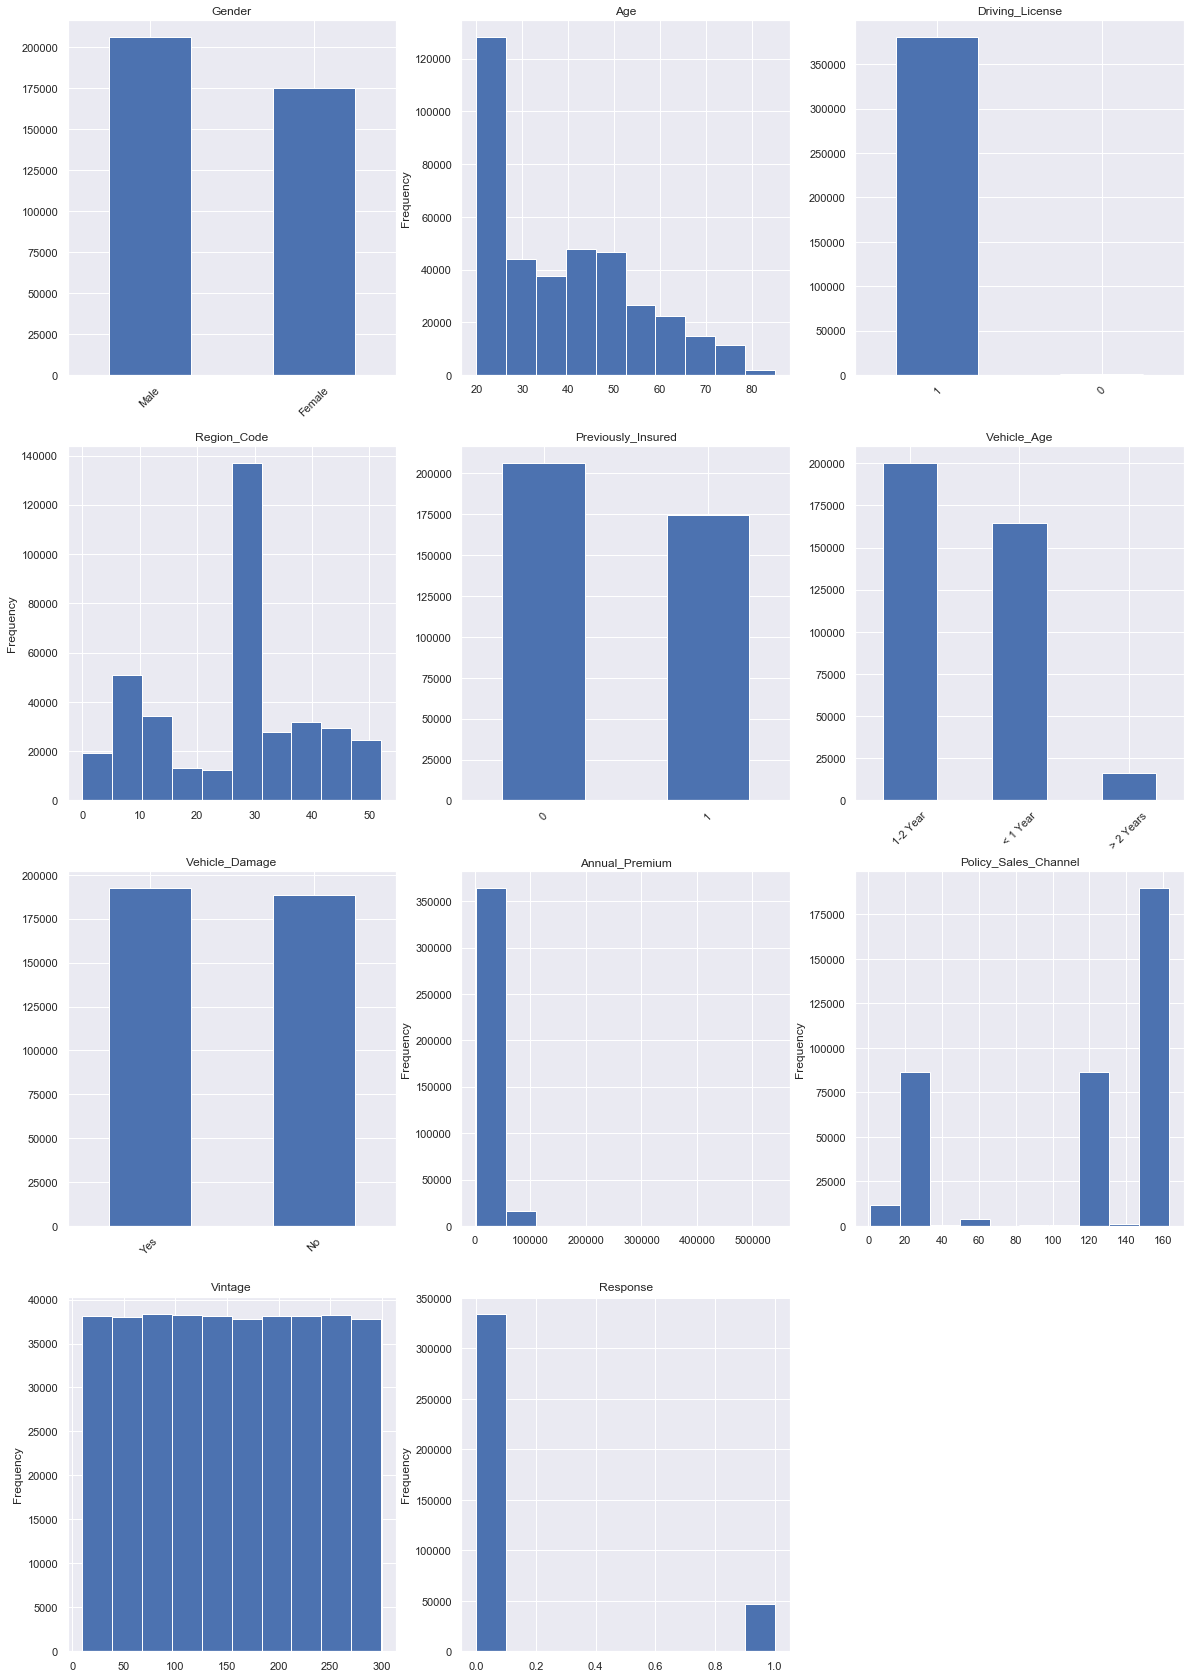

In [5]:
# Visualising distribution 

fig = plt.figure(figsize=(20,30))
axs = []

binary_col = [2,4]

for n in range(11):
    ax = fig.add_subplot(4, 3, n+1)
    col = sell_data_train.columns[n]
    if n in binary_col or sell_data_train[col].dtype == object:
        sell_data_train[col].value_counts(dropna=False).plot(
            kind='bar',
            ax=ax,
            include_bool=True,
            title=sell_data_train.columns[n]
        )
        ax.tick_params(axis='x', rotation=45)
    else:
        sell_data_train[col].plot(kind='hist', ax=ax, title=sell_data_train.columns[n])

(0, 150000)

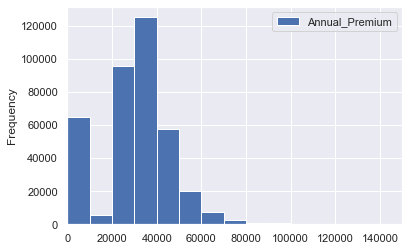

In [28]:
# Looking at 'Annual Premium' in more detail

ax = sell_data_train[['Annual_Premium']].plot(kind='hist', bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000])
ax.set_xlim(0,150000)

<b>Some observations / to-do </b><br>
- Need to <b>encode</b> 'Gender' (one-hot), 'Vehicle_Damage' (one-hot), 'Vehicle_Age' (ordinal)
- Need to <b>scale</b> 'Age', 'Region_Code, 'Policy_Sales_Channel', 'Vintage'
- 'Age', 'Region_Code', 'Policy_Sales_Channel' are <b>skewed</b>. Check dictionary for meaning of last two columns. Keep in mind for later.
- 'Driving_License' is '1' for all instances, so has no predictive value. Let's drop it. 
- There is significant <b>class imbalance in the target class</b>! The positive class (i.e. successful sale) is much less common. If models don't work well, will use oversampling to improve training.

## Data preparation

In [8]:
# Setting y

y_train = sell_data_train[['Response']].to_numpy().ravel()

# Dropping license, transforming other cols, setting X_train

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

hot_ft = [0, 6]
ord_ft = [5]
drop_ft = [2, 10]

ct = ColumnTransformer(
    transformers=[('to_drop', 'drop', drop_ft),
        ('ordinal', OrdinalEncoder([['< 1 Year', '1-2 Year', '> 2 Years']]), ord_ft),
        ('one_hot', OneHotEncoder(), hot_ft)],
    remainder='passthrough')

X_train = ct.fit_transform(sell_data_train)

## Training and testing

Performance metrics: F1 score
- The overall goal here is two-fold: recruit as many customers as possible, but at the same time not waste our resources on the wrong customers.
- Mathematically speaking, we want high recall and high precision. 
- The F1 score combines recall and precision in one metric, so it is ideal for this purpose.

Models: logistic regression (with elastic net regularisation), support vector classifier (gaussian kernel), random forest  

### Loading, transforming test data

In [9]:
# Loading test data
sell_data_test = pd.read_csv('train.csv', index_col='id')

# Double-checking test data
sell_data_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [10]:
sell_data_test.shape

(381109, 11)

In [11]:
# Transforming test data

y_test = sell_data_test[['Response']].to_numpy().ravel()
X_test = ct.transform(sell_data_test)

### Logistic regression

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

scorer_f1 = make_scorer(f1_score)

In [ ]:
# log_model = SGDClassifier(loss='log', penalty='elasticnet')
# scores = cross_val_score(log_model, X_train, y_train, scoring=scorer_f1)

In [18]:
from sklearn.linear_model import LogisticRegression

log_model_2 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
scores = cross_val_score(log_model_2, X_train, y_train, scoring=scorer_f1)

C:\Users\crmw\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\crmw\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 